In [33]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection  import train_test_split
import numpy as np
from scipy.stats import norm # for scientific Computing
from scipy import stats, integrate
import matplotlib.pyplot as plt


In [34]:
#train =  pd.read_csv('../input/ashrae-great-energy-prediction/train.csv')
ASHRAE_test = pd.read_csv("/content/ashrae-energy-prediction/test.csv")
ASHRAE_train = pd.read_csv("/content/ashrae-energy-prediction/train.csv")
weather_train = pd.read_csv("/content/ashrae-energy-prediction/weather_train.csv")
building_meta = pd.read_csv("/content/ashrae-energy-prediction/building_metadata.csv")
weather_test = pd.read_csv("/content/ashrae-energy-prediction/weather_test.csv")
weather_train = pd.read_csv("/content/ashrae-energy-prediction/weather_train.csv")
weather_test = pd.read_csv("/content/ashrae-energy-prediction/weather_test.csv")


In [35]:
ASHRAE_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6885267 entries, 0 to 6885266
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 210.1+ MB


In [36]:
weather_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [37]:
## Function to reduce the DF size
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [38]:
reduce_memory_usage(building_meta)
reduce_memory_usage(weather_train)
reduce_memory_usage(ASHRAE_train)

reduce_memory_usage(weather_test)
reduce_memory_usage(ASHRAE_test)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 98.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to 97.20 Mb (53.1% reduction)


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
6794621,6794621,158,0,2018-05-12 18:00:00
6794622,6794622,159,0,2018-05-12 18:00:00
6794623,6794623,160,0,2018-05-12 18:00:00
6794624,6794624,161,0,2018-05-12 18:00:00


In [39]:
ASHRAE_train.describe()


,building_id,meter,meter_reading
count,6.885267e+06,6.885267e+06,6.885266e+06
mean,7.871691e+02,6.549472e-01,3.255322e+03
std,4.207114e+02,9.332858e-01,1.923791e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.840000e+02,0.000000e+00,1.340000e+01
50%,8.870000e+02,0.000000e+00,6.871490e+01
75%,1.159000e+03,1.000000e+00,2.367500e+02
max,1.448000e+03,3.000000e+00,2.172440e+07


In [40]:
print('Size of the building dataset is', building_meta.shape)
print('Size of the weather_train dataset is', weather_train.shape)
print('Size of the train dataset is', ASHRAE_train.shape)


Size of the building dataset is (1449, 6)
Size of the weather_train dataset is (139773, 9)
Size of the train dataset is (6885267, 4)


In [41]:
ASHRAE_train.describe()


,building_id,meter,meter_reading
count,6.885267e+06,6.885267e+06,6.885266e+06
mean,7.871691e+02,6.549472e-01,3.255322e+03
std,4.207114e+02,9.332858e-01,1.923791e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.840000e+02,0.000000e+00,1.340000e+01
50%,8.870000e+02,0.000000e+00,6.871490e+01
75%,1.159000e+03,1.000000e+00,2.367500e+02
max,1.448000e+03,3.000000e+00,2.172440e+07


In [42]:
building_meta.describe()


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.0000,355.000000
mean,6.952381,724.000000,92111.776398,inf,3.740234
std,5.003432,418.434583,110769.950997,31.0625,3.333984
min,0.000000,0.000000,283.000000,1900.0000,1.000000
25%,3.000000,362.000000,23012.000000,1949.0000,1.000000
50%,5.000000,724.000000,57673.000000,1970.0000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.0000,5.000000
max,15.000000,1448.000000,875000.000000,2017.0000,26.000000


In [43]:
primary_use_numbersOfUniqueValue = building_meta['primary_use'].nunique()

print('Number of unique values in column "primary_use" of the building_meta : ')
print(primary_use_numbersOfUniqueValue)
primary_use_element = building_meta['primary_use'].unique()

print('Unique element in column "primary_use" of the building_meta : ')
print(primary_use_element)


Number of unique values in column "primary_use" of the building_meta : 
16
Unique element in column "primary_use" of the building_meta : 
['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']


In [44]:
print('Columns of the building dataset is', building_meta.columns)
print('Columns of the weather_train dataset is', weather_train.columns)
print('Columns of the train dataset is', ASHRAE_train.columns)

Columns of the building dataset is Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')
Columns of the weather_train dataset is Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
Columns of the train dataset is Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')


<Axes: >

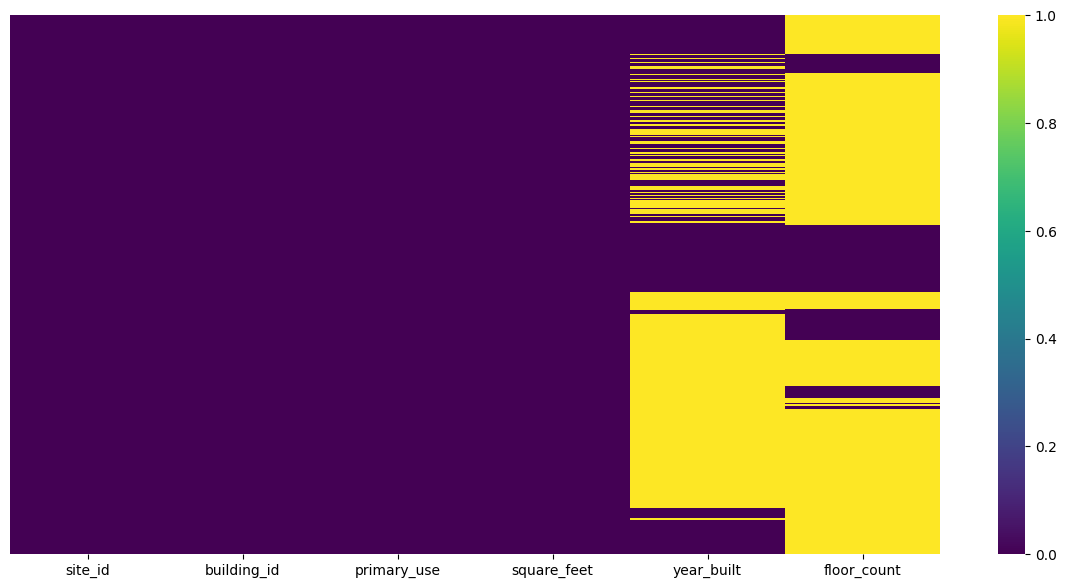

In [45]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(building_meta.isnull(), yticklabels=False,cmap='viridis')

In [46]:
print("Percentage of missing values in the building_meta dataset")
building_meta.isna().sum()/len(building_meta)*100

Percentage of missing values in the building_meta dataset


,0
site_id,0.000000
building_id,0.000000
primary_use,0.000000
square_feet,0.000000
year_built,53.416149
floor_count,75.500345


In [47]:
print("Percentage of missing values in the train dataset")
ASHRAE_train.isna().sum()/len(ASHRAE_train)*100


Percentage of missing values in the train dataset


,0
building_id,0.000000
meter,0.000000
timestamp,0.000000
meter_reading,0.000015


In [48]:
#pd.merge(df1, df2, on='employee')
BuildingTrainMerge=building_meta.merge(ASHRAE_train,left_on='building_id',right_on='building_id',how='left')
BuildingTrainMerge.shape


(6885277, 9)

In [49]:
BTW_train=BuildingTrainMerge.merge(weather_train,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')
BTW_train.shape


(6885277, 16)

In [50]:
BTW_train.columns


Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'meter', 'timestamp', 'meter_reading', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

In [51]:
print("Percentage of missing values in the BTW_train dataset")
BTW_train.isna().sum()/len(BTW_train)*100

Percentage of missing values in the BTW_train dataset


,0
site_id,0.000000
building_id,0.000000
primary_use,0.000000
square_feet,0.000000
year_built,61.547676
floor_count,82.046285
meter,0.000145
timestamp,0.000145
meter_reading,0.000160
air_temperature,0.560166


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1019: RuntimeWarning: invalid value encountered in scalar divide
  result = sqr.sum(axis=axis, dtype=np.float64) / d


,sea_level_pressure
count,6436300.0
mean,NaN
std,NaN
min,968.0
25%,1011.0
50%,1016.5
75%,1021.5
max,1043.0


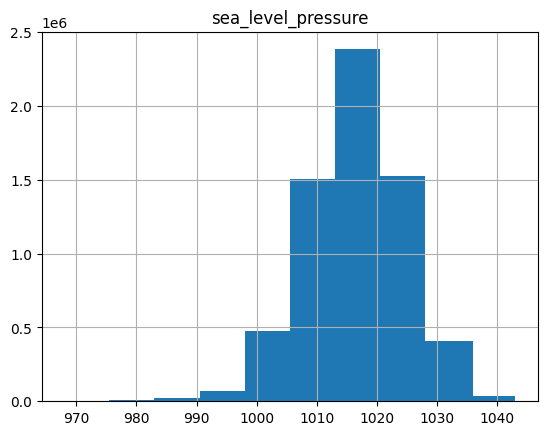

In [52]:
BTW_train.hist('sea_level_pressure')
BTW_train[['sea_level_pressure']].describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,cloud_coverage
count,3635404.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,4.0
max,9.0


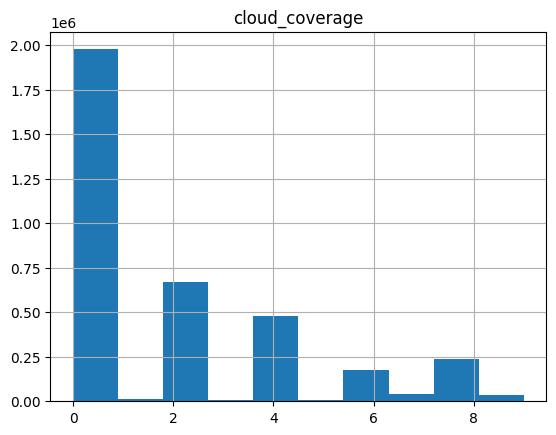

In [53]:
BTW_train.hist('cloud_coverage')
BTW_train[['cloud_coverage']].describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1019: RuntimeWarning: invalid value encountered in scalar divide
  result = sqr.sum(axis=axis, dtype=np.float64) / d


,precip_depth_1_hr
count,5727524.0
mean,NaN
std,NaN
min,-1.0
25%,0.0
50%,0.0
75%,0.0
max,343.0


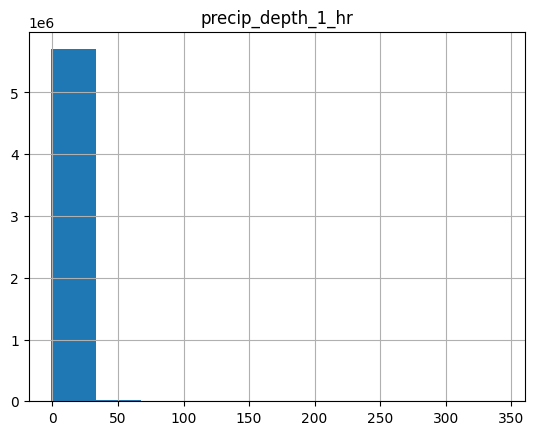

In [54]:
BTW_train.hist('precip_depth_1_hr')
BTW_train[['precip_depth_1_hr']].describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,wind_speed
count,6.834059e+06
mean,NaN
std,0.000000e+00
min,0.000000e+00
25%,2.099609e+00
50%,3.099609e+00
75%,5.101562e+00
max,1.900000e+01


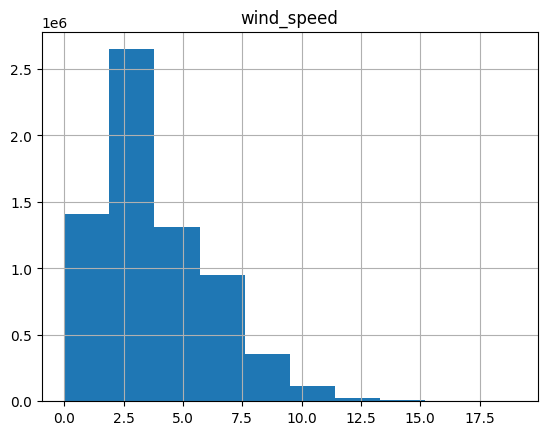

In [55]:
BTW_train.hist('wind_speed')
BTW_train[['wind_speed']].describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,air_temperature
count,6.846708e+06
mean,NaN
std,0.000000e+00
min,-2.879688e+01
25%,3.300781e+00
50%,1.000000e+01
75%,1.720312e+01
max,3.831250e+01


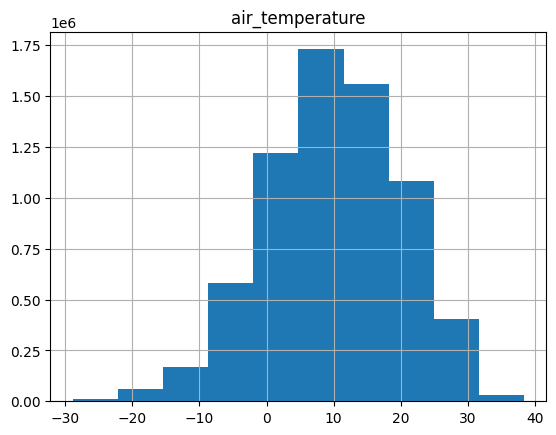

In [56]:
BTW_train.hist(column='air_temperature')
BTW_train[['air_temperature']].describe()

<Axes: xlabel='meter', ylabel='meter_reading'>

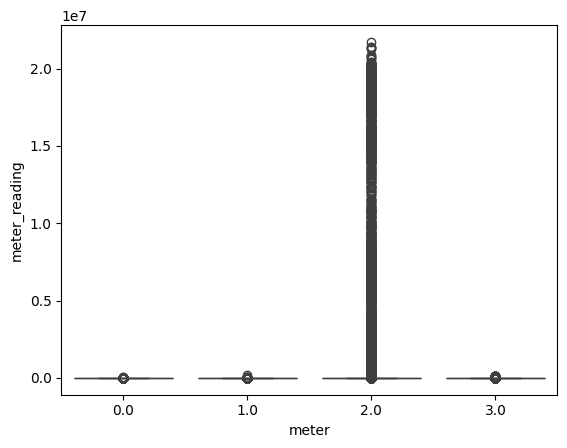

In [57]:
sns.boxplot(x = 'meter', y = 'meter_reading', data = BTW_train)


In [58]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(
        np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(
        np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile

    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0

    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count


In [59]:
print("{} percent of {} are outliers."
      .format((
              (100 * outlier_function(BTW_train, 'meter_reading')[2])
               / len(BTW_train['meter_reading'])),
              'meter_reading'))

0.0 percent of meter_reading are outliers.


Text(0.5, 1.0, 'Density of Logartihm(Meter Reading + 1) Among Different Meters')

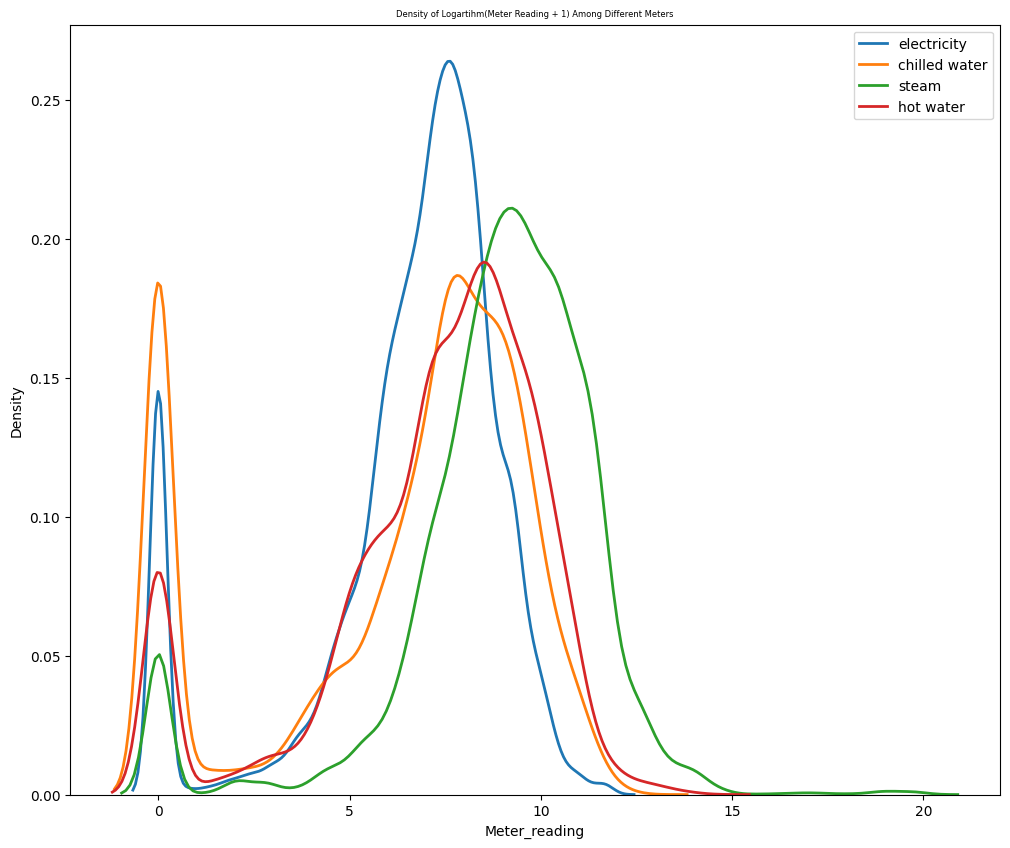

In [88]:
# Distribution of the meter reading in meters without zeros
plt.figure(figsize=(12,10))

#list of different meters
meters = sorted(BTW_train['meter'].unique().tolist())

# plot meter_reading distribution for each meter
for meter_type in meters:
    subset = BTW_train[BTW_train['meter'] == meter_type]
    sns.kdeplot(np.log1p(subset["meter_reading"]),
                label=meter_type, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Meter_reading")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("Density of Logartihm(Meter Reading + 1) Among Different Meters", size=14)


In [61]:
BTW_train.columns


Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'meter', 'timestamp', 'meter_reading', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

<Axes: >

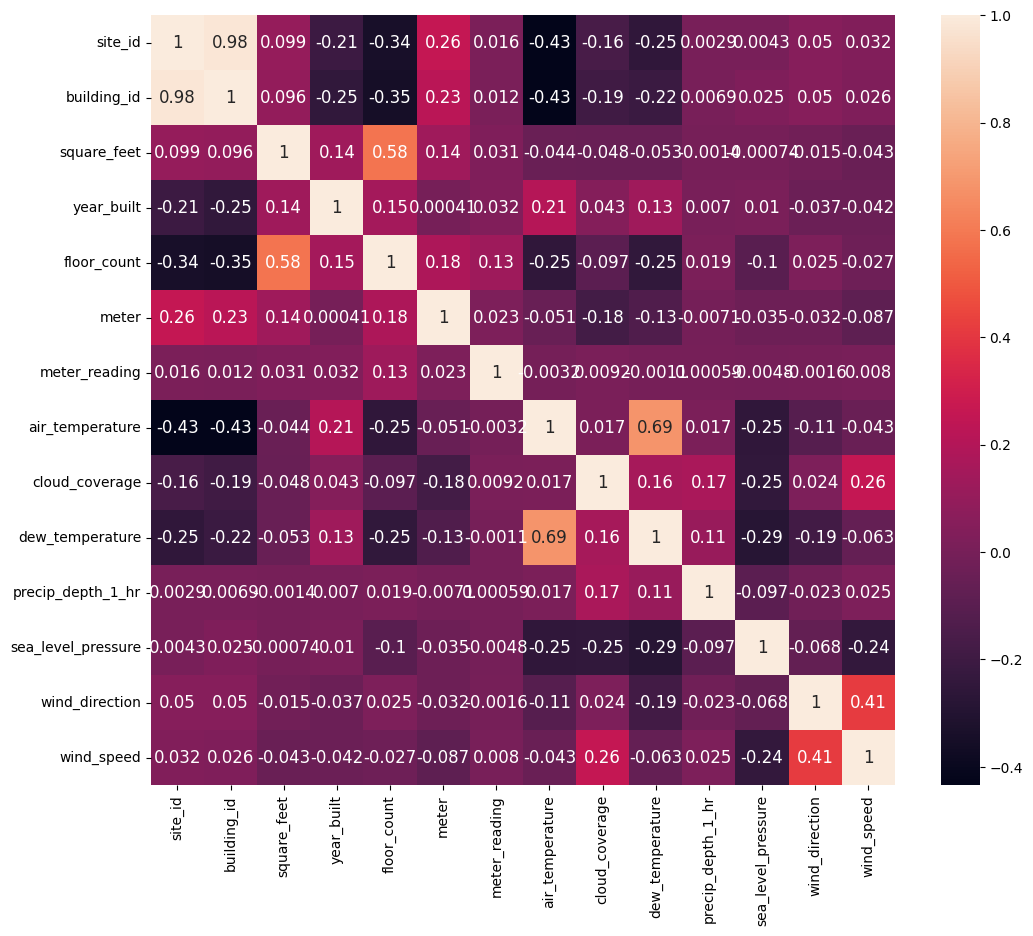

In [62]:
# Select only numeric columns from the DataFrame
numeric_columns = BTW_train.select_dtypes(include=['number'])

# Compute the correlation matrix
corrmat = numeric_columns.corr()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, annot=True, annot_kws={'size': 12})

In [63]:
# Get the list of columns in the DataFrame
existing_columns = BTW_train.columns.tolist()

# Columns to drop
columns_to_drop = ['year_built', 'floor_count', 'wind_direction', 'dew_temperature']

# Find the common columns between the existing columns and the columns to drop
common_columns = list(set(existing_columns) & set(columns_to_drop))

# Drop only the common columns if they exist
if common_columns:
    BTW_train = BTW_train.drop(columns=common_columns)
else:
    print("None of the specified columns were found in the DataFrame.")

# Continue with the rest of your code
BTW_train['timestamp'] = pd.to_datetime(BTW_train['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
BTW_train['timestamp'] = BTW_train['timestamp'].fillna(pd.Timestamp('2000-01-01 00:00:00'))
BTW_train['Month'] = pd.DatetimeIndex(BTW_train['timestamp']).month
BTW_train['Day'] = pd.DatetimeIndex(BTW_train['timestamp']).day

In [64]:
BTW_train= BTW_train.groupby(['meter',BTW_train['building_id'],'primary_use',BTW_train['Month'], BTW_train['Day']]).agg({'meter_reading':'sum', 'air_temperature': 'mean', 'wind_speed': 'mean', 'precip_depth_1_hr': 'mean', 'cloud_coverage': 'mean', 'square_feet': 'mean'})

In [65]:
BTW_train.columns


Index(['meter_reading', 'air_temperature', 'wind_speed', 'precip_depth_1_hr',
       'cloud_coverage', 'square_feet'],
      dtype='object')

In [66]:
BTW_train = BTW_train.reset_index()


In [67]:
BTW_train.describe()


,meter,building_id,Month,Day,meter_reading,air_temperature,wind_speed,precip_depth_1_hr,cloud_coverage,square_feet
count,289509.000000,289509.000000,289509.000000,289509.000000,2.895090e+05,289508.000000,289508.000000,252910.000000,265550.000000,289509.000000
mean,0.656691,788.360434,2.662860,14.881375,7.741994e+04,9.829030,3.665166,0.775515,2.572659,108237.914148
std,0.933658,420.960361,1.262366,8.946777,4.418488e+06,9.340764,1.747348,2.762948,2.571880,118084.266515
min,0.000000,0.000000,1.000000,1.000000,0.000000e+00,-24.925131,0.000000,-1.000000,0.000000,283.000000
25%,0.000000,385.000000,2.000000,7.000000,3.976000e+02,3.520223,2.356323,0.000000,0.300000,32256.000000
50%,0.000000,887.000000,3.000000,14.000000,1.786400e+03,10.496745,3.344005,0.000000,1.764706,72332.000000
75%,1.000000,1161.000000,4.000000,23.000000,5.829453e+03,17.171225,4.654215,0.000000,4.000000,140092.000000
max,3.000000,1448.000000,5.000000,31.000000,4.552247e+08,30.474865,14.416667,43.416668,9.000000,875000.000000


In [68]:
BTW_train['wind_speed'] = BTW_train['wind_speed'].astype('float32')
BTW_train['air_temperature'] = BTW_train['air_temperature'].astype('float32')
BTW_train['precip_depth_1_hr'] = BTW_train['precip_depth_1_hr'].astype('float32')
BTW_train['cloud_coverage'] = BTW_train['cloud_coverage'].astype('float32')

In [69]:
BTW_train['precip_depth_1_hr'].fillna(method='ffill', inplace = True)
BTW_train['cloud_coverage'].fillna(method='bfill', inplace = True)

BTW_train['wind_speed'].fillna(BTW_train['wind_speed'].mean(), inplace=True)
BTW_train['air_temperature'].fillna(BTW_train['air_temperature'].mean(), inplace=True)
BTW_train.isnull().sum()

<ipython-input-69-e6262483b522>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  BTW_train['precip_depth_1_hr'].fillna(method='ffill', inplace = True)
<ipython-input-69-e6262483b522>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BTW_train['precip_depth_1_hr'].fillna(method='ffill', inplace = True)
<ipython-input-69-e6262483b522>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment u

,0
meter,0
building_id,0
primary_use,0
Month,0
Day,0
meter_reading,0
air_temperature,0
wind_speed,0
precip_depth_1_hr,0
cloud_coverage,1


In [70]:
BTW_train.shape


(289509, 11)

In [71]:
BTW_train.dtypes


,0
meter,float64
building_id,int16
primary_use,object
Month,int32
Day,int32
meter_reading,float32
air_temperature,float32
wind_speed,float32
precip_depth_1_hr,float32
cloud_coverage,float32


In [72]:
BTW_train.columns


Index(['meter', 'building_id', 'primary_use', 'Month', 'Day', 'meter_reading',
       'air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet'],
      dtype='object')

In [73]:
BTW_linearR = pd.get_dummies(BTW_train, columns=['primary_use'])


In [74]:
BTW_linearR.columns


Index(['meter', 'building_id', 'Month', 'Day', 'meter_reading',
       'air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet', 'primary_use_Education',
       'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage'],
      dtype='object')

In [75]:
X =BTW_linearR[['building_id', 'meter', 'air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet', 'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'Month', 'Day']]

# Create target variable
y = BTW_linearR['meter_reading']

# Train, test, split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state= 0)

In [76]:
# Impute missing values using SimpleImputer
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined as in your code

# Create an imputer to replace NaN with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to your training data and transform it
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)  # Transform the test data as well

# Convert the imputed data back to a pandas DataFrame (optional but recommended)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

# Create linear regression object
regressor = LinearRegression()

# Fit model to the imputed training data
regressor.fit(X_train_imputed, y_train) # Changed to use imputed data

LinearRegression()

In [77]:
# Predicting test set results
y_pred = regressor.predict(X_test)

In [78]:
print('Accuracy %d', regressor.score(X_test, y_test))


Accuracy %d 0.0013124585560282398


In [79]:
#Calculate R Sqaured
print('R^2 =',metrics.explained_variance_score(y_test,y_pred))#Calculate R Sqaured
print('R^2 =',metrics.explained_variance_score(y_test,y_pred))


R^2 = 0.00136869212184354
R^2 = 0.00136869212184354


In [80]:
cdf = pd.DataFrame(data = regressor.coef_, index = X.columns, columns = ['Coefficients'])
cdf


,Coefficients
building_id,129.913107
meter,107130.789514
air_temperature,422.904590
wind_speed,38009.009097
precip_depth_1_hr,-14325.727453
cloud_coverage,39340.277433
square_feet,1.134241
primary_use_Education,153439.182725
primary_use_Entertainment/public assembly,-17650.026193
primary_use_Food sales and service,10837.746505


<Axes: >

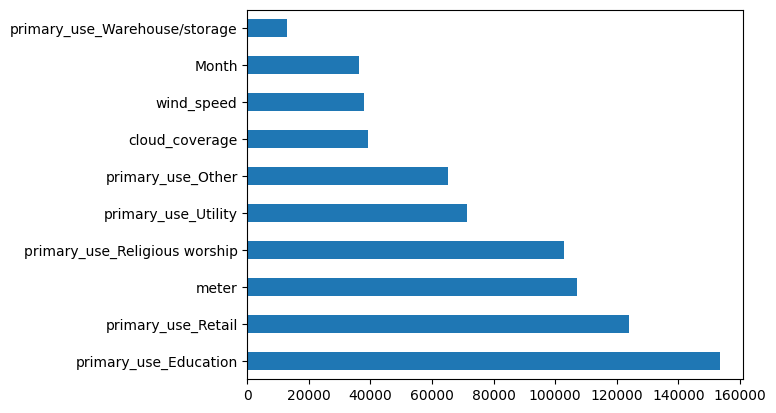

In [81]:
cdf.Coefficients.nlargest(10).plot(kind='barh')


In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [83]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [84]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X, y, cv=5)
print('Cross-Validation Scores:', scores)


Cross-Validation Scores: [nan nan nan nan nan]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 143, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 848, in score
    y_pred = self.predict(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_base.py", line 306, in predict
    return self._decision_function(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_base.py", line 285, in _decision_function
    X = self._validate_data(X, accept_sparse=["csr", "csc", "coo"], reset=False)
  F

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# ... (your existing code) ...

feature_importance = reg.coef_

# 1. Convert feature_names to a list of strings
feature_names_list = list(map(str, feature_names))

# 2. Ensure feature_names and feature_importance have the same length
# Assuming 'X' has 25 features, adjust if necessary
num_features = X.shape[1]
feature_names_list = feature_names_list + [f'feature_{i}' for i in range(len(feature_names_list), num_features)]

plt.barh(feature_names_list, feature_importance)
plt.show()

NameError: name 'reg' is not defined

In [ ]:
import pandas as pd
import shap


# Convert all columns in X_test to numeric types
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')

# Impute missing values with the mean of each column
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test_numeric)

# Convert the imputed array back to a DataFrame
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Now, generate SHAP values and create the summary plot using the imputed DataFrame
explainer = shap

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Initialize model
model = RandomForestClassifier()

# Perform k-fold cross-validation (e.g., k=5)
k = 5
scores = cross_val_score(model, X, y, cv=k)

# Print cross-validation scores
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')
